In [1]:
pip install rasterio numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import numpy as np

In [3]:
dsm_path = 'Rst/DEM_040524'  # Modelo de Superficie
dtm_path = 'Rst/DEM_130424'  # Modelo del Terreno
chm_output_path = 'Rst/CHM.tif'  # Modelo de Altura de Vegetación

In [13]:
# Abrir raster de referencia (DEM_13042)
with rasterio.open(r'C:\Users\seflo\Rst\DEM_130424.tif') as ref:
    ref_profile = ref.profile
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = ref.shape

# Abrir raster a remuestrear (DEM_040524)
with rasterio.open(r'C:\Users\seflo\Rst\DEM_040524.tif') as src:
    src_data = src.read(1)
    src_transform = src.transform
    src_crs = src.crs

    # Crear array de salida con forma del raster de referencia
    resampled_data = np.empty(ref_shape, dtype=src_data.dtype)

    # Ejecutar el remuestreo
    reproject(
        source=src_data,
        destination=resampled_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )

In [14]:
# Guardar raster remuestreado (opcional)
out_profile = ref_profile.copy()
out_profile.update(dtype=src_data.dtype, count=1)

with rasterio.open('Rst/DEM_040524_remuestreado.tif', 'w', **out_profile) as dst:
    dst.write(resampled_data, 1)

In [15]:
papaRaster = rasterio.open('Rst/DEM_040524_remuestreado.tif')

In [16]:
# Cargar shapefile del área de estudio
area_estudio = gpd.read_file("Shp/Shp Lote.shp")
area_estudio = area_estudio.to_crs(papaRaster.crs)  # Asegurar mismo CRS


In [17]:
# Extraer geometría del área de estudio
geoms = area_estudio.geometry.values
geoms = [geom.__geo_interface__ for geom in geoms]


In [18]:
# Rutas
dsm_path = "Rst/DEM_040524.tif"
shapefile_path = "Shp/Shp Lote.shp"

# Leer shapefile
area_estudio = gpd.read_file(shapefile_path)

# Abrir raster y reproyectar el shapefile a su CRS
with rasterio.open(dsm_path) as src:
    area_estudio = area_estudio.to_crs(src.crs)
    geoms = [g.__geo_interface__ for g in area_estudio.geometry]
    
    dsm_clip, dsm_transform = mask(src, geoms, crop=True)
    dsm_meta = src.meta.copy()

# Actualizar metadatos
dsm_meta.update({
    "height": dsm_clip.shape[1],
    "width": dsm_clip.shape[2],
    "transform": dsm_transform
})

# Guardar el recorte
with rasterio.open("Rst/DEM_clip_040524.tif", "w", **dsm_meta) as dest:
    dest.write(dsm_clip)

In [19]:
# Rutas
dtm_path = "Rst/DEM_130424.tif"
shapefile_path = "Shp/Shp Lote.shp"

# Leer shapefile
area_estudio = gpd.read_file(shapefile_path)

# Abrir raster y reproyectar el shapefile a su CRS
with rasterio.open(dtm_path) as src:
    area_estudio = area_estudio.to_crs(src.crs)
    geoms = [g.__geo_interface__ for g in area_estudio.geometry]
    
    dtm_clip, dtm_transform = mask(src, geoms, crop=True)
    dtm_meta = src.meta.copy()

# Actualizar metadatos
dtm_meta.update({
    "height": dtm_clip.shape[1],
    "width": dtm_clip.shape[2],
    "transform": dtm_transform
})

# Guardar el recorte
with rasterio.open("Rst/DEM_clip_130424.tif", "w", **dtm_meta) as dest:
    dest.write(dtm_clip)

In [20]:
# Abrir DSM
with rasterio.open("Rst/DEM_clip_040524.tif") as dsm_src:
    dsm = dsm_src.read(1)

    # Crear arreglo vacío con la forma del DTM
    dsm_resampled = np.empty_like(dtm, dtype=np.float32)

    # Reproyectar DSM al tamaño y proyección del DTM
    reproject(
        source=dsm,
        destination=dsm_resampled,
        src_transform=dsm_src.transform,
        src_crs=dsm_src.crs,
        dst_transform=dtm_meta["transform"],
        dst_crs=dtm_meta["crs"],
        resampling=Resampling.bilinear
    )

# Convertir nodata o NaN a cero
dsm_resampled = np.nan_to_num(dsm_resampled, nan=0.0)
dtm = np.nan_to_num(dtm, nan=0.0)

# Calcular altura de plantas
altura = dsm_resampled - dtm

# Forzar a cero cualquier valor negativo
altura[altura < 0] = 0

# Guardar resultado
dtm_meta.update(dtype=rasterio.float32)

with rasterio.open("Rst/Altura_Plantas.tif", "w", **dtm_meta) as dst:
    dst.write(altura.astype(np.float32), 1)

NameError: name 'dtm' is not defined

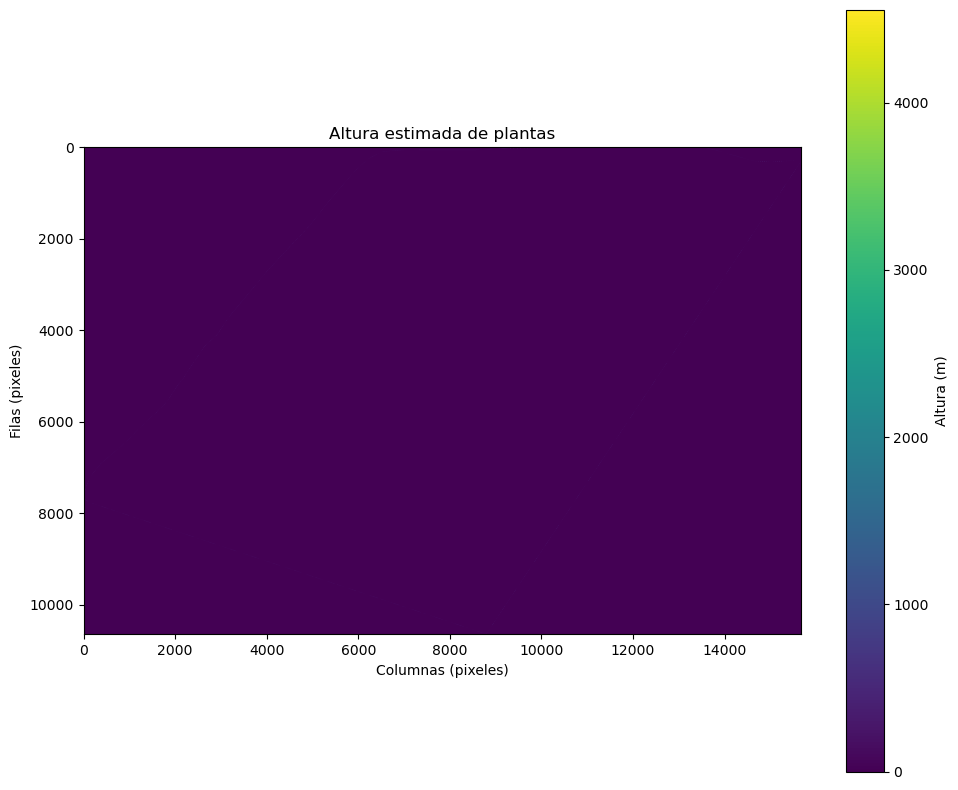

In [21]:
# === Cálculo de altura de plantas usando DSM remuestreado y DTM ===

import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# === Abrir DTM (terreno) ===
with rasterio.open(r'C:\Users\seflo\Rst\DEM_130424.tif') as dtm_src:
    dtm = dtm_src.read(1).astype('float32')
    dtm_transform = dtm_src.transform
    dtm_crs = dtm_src.crs
    dtm_shape = dtm.shape
    dtm_profile = dtm_src.profile

# === Abrir DSM (superficie) ===
with rasterio.open(r'C:\Users\seflo\Rst\DEM_040524.tif') as dsm_src:
    dsm = dsm_src.read(1).astype('float32')
    dsm_transform = dsm_src.transform
    dsm_crs = dsm_src.crs

# === Remuestrear DSM al DTM ===
dsm_resampled = np.empty(dtm_shape, dtype='float32')

reproject(
    source=dsm,
    destination=dsm_resampled,
    src_transform=dsm_transform,
    src_crs=dsm_crs,
    dst_transform=dtm_transform,
    dst_crs=dtm_crs,
    resampling=Resampling.bilinear
)

# === Calcular altura de plantas ===
altura_plantas = dsm_resampled - dtm
altura_plantas[altura_plantas < 0] = 0  # Eliminar valores negativos

# === Guardar resultado como nuevo raster ===
output_profile = dtm_profile.copy()
output_profile.update(dtype='float32', count=1)

with rasterio.open(r'C:\Users\seflo\Rst\Altura_Plantas.tif', 'w', **output_profile) as dst:
    dst.write(altura_plantas, 1)

# === Visualizar el raster de altura de plantas ===
with rasterio.open(r'C:\Users\seflo\Rst\Altura_Plantas.tif') as src:
    altura = src.read(1)

plt.figure(figsize=(10, 8))
plt.imshow(altura, cmap='viridis')
plt.colorbar(label='Altura (m)')
plt.title('Altura estimada de plantas')
plt.xlabel('Columnas (pixeles)')
plt.ylabel('Filas (pixeles)')
plt.grid(False)
plt.tight_layout()
plt.show()
